Import modules and dataset



In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn import discriminant_analysis as da
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, accuracy_score

from scipy.special import expit
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Global YouTube Statistics.csv'
df = pd.read_csv(path, encoding='latin1')
df

Mounted at /content/drive


,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,245000000,2.280000e+11,Music,T-Series,20082,India,IN,Music,...,2000000.0,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,YouTube Movies,170000000,0.000000e+00,Film & Animation,youtubemovies,1,United States,US,Games,...,NaN,2006.0,Mar,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,MrBeast,166000000,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,Natan por AÃ¯Â¿,12300000,9.029610e+09,Sports,Natan por AÃ¯Â¿,1200,Brazil,BR,Entertainment,...,700000.0,2017.0,Feb,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280
991,992,Free Fire India Official,12300000,1.674410e+09,People & Blogs,Free Fire India Official,1500,India,IN,Games,...,300000.0,2018.0,Sep,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
992,993,Panda,12300000,2.214684e+09,NaN,HybridPanda,2452,United Kingdom,GB,Games,...,1000.0,2006.0,Sep,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973
993,994,RobTopGames,12300000,3.741235e+08,Gaming,RobTopGames,39,Sweden,SE,Games,...,100000.0,2012.0,May,9.0,67.0,1.028545e+07,6.48,9021165.0,60.128161,18.643501


The Following Section contains the Module 1 code because Module 2 will not run properly without it.

In [ ]:
df['video views'] = df['video views'].replace(0, np.nan)
df = df.dropna(subset=['video views'])

df['subscribers'] = df['subscribers'].replace(0, np.nan)
df = df.dropna(subset=['subscribers'])

# Lower bound uploads is a requirement we have made for a channel to demonstrate that they are not one-hit wonders and have dedicated time to being a YouTuber.
lower_bound_uploads = 50

df = df[df['uploads'] >= lower_bound_uploads]

# Channels of the music type are channels such as VEVO and other labels.
# We do not consider these channels as YouTubers as they only upload music videos of artists signed to them.
df = df[df['channel_type'] != 'Music']

df['log_uploads'] = np.log1p(df['uploads'])
df['log_video_views'] = np.log1p(df['video views'])
df['log_subscribers'] = np.log1p(df['subscribers'])

q1 = df['log_video_views'].quantile(0.25)
q3 = df['log_video_views'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df.loc[(df['log_video_views'] >= lower_bound) & (df['log_video_views'] <= upper_bound)]


<ipython-input-3-54b8dd674ce7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subscribers'] = df['subscribers'].replace(0, np.nan)


In [ ]:
q1s = df['log_subscribers'].quantile(0.25)
q3s = df['log_subscribers'].quantile(0.75)
iqrs = q3s - q1s

lower_bounds = q1s - 1.5 * iqrs
upper_bounds = q3s + 1.5 * iqrs

df = df.loc[(df['log_subscribers'] >= lower_bounds) & (df['log_subscribers'] <= upper_bounds)]

Module 3: Data Modeling

Linear Regression MSE:
Views: 0.5275498661905311
Subscribers: 0.10215178872596449


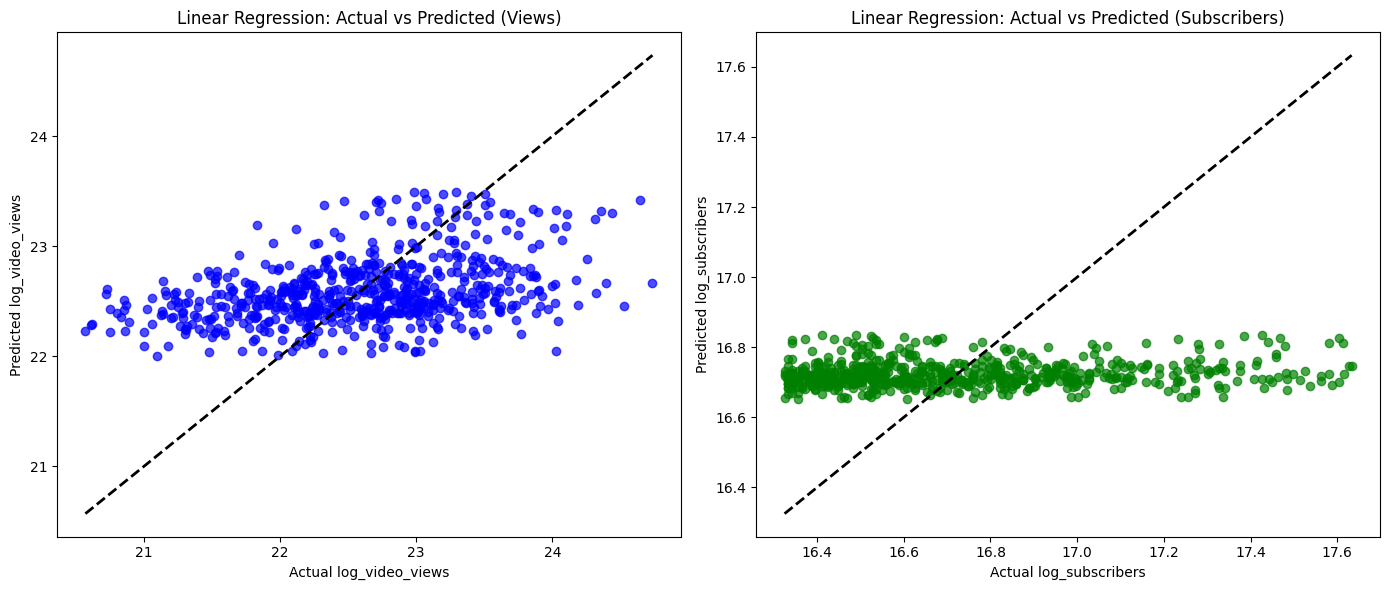

In [ ]:
# Regression Model
X = df[['log_uploads']]
y_views = df['log_video_views']
y_subscribers = df['log_subscribers']

model_views = linear_model.LinearRegression().fit(X, y_views)
model_subscribers = linear_model.LinearRegression().fit(X, y_subscribers)

y_views_pred = model_views.predict(X)
y_subscribers_pred = model_subscribers.predict(X)

#calculating mean squared error

mse_views = mean_squared_error(y_views, y_views_pred)
mse_subscribers = mean_squared_error(y_subscribers, y_subscribers_pred)

print("Linear Regression MSE:")
print(f"Views: {mse_views}")
print(f"Subscribers: {mse_subscribers}")

plt.figure(figsize=(14, 6))

# Chart for Views
plt.subplot(1, 2, 1)
plt.scatter(y_views, y_views_pred, alpha=0.7, color='blue')
plt.plot([y_views.min(), y_views.max()], [y_views.min(), y_views.max()], 'k--', lw=2)
plt.title('Linear Regression: Actual vs Predicted (Views)')
plt.xlabel('Actual log_video_views')
plt.ylabel('Predicted log_video_views')

# Chart for Subscribers
plt.subplot(1, 2, 2)
plt.scatter(y_subscribers, y_subscribers_pred, alpha=0.7, color='green')
plt.plot([y_subscribers.min(), y_subscribers.max()], [y_subscribers.min(), y_subscribers.max()], 'k--', lw=2)
plt.title('Linear Regression: Actual vs Predicted (Subscribers)')
plt.xlabel('Actual log_subscribers')
plt.ylabel('Predicted log_subscribers')

plt.tight_layout()
plt.show()

Linear Regression was effective in predicting continuous outcomes like log_video_views and log_subscribers. Its simplicity and interpretability, notably through its coefficients, make it useful in determining feature significance. However, it requires a linear connection between predictors and targets, which may not be true for complicated datasets, and it is susceptible to outliers. Its performance was assessed using Mean Squared Error (MSE), which provides a quantitative indicator of prediction error. Linear Regression performed effectively on this dataset since the connection between characteristics and targets was relatively linear. The model's prediction accuracy is measured using Mean Squared Error (MSE), with lower values suggesting a better match. The results indicate that the model was effective, most likely due to the reasonably linear connection between upload count and the dependent variables. The findings, supported by pictorial data, show that increasing upload rates boosts viewing, though the link with subscriber count is less significant. Data points along the "perfect" line show a stronger relationship.


kNN Accuracy: 0.5412371134020618


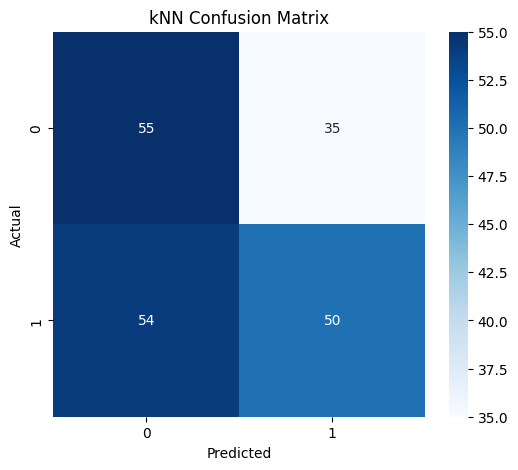

In [ ]:
#kNN Model
median_views = y_views.median()
y_views_binary = (y_views > median_views).astype(int)

#separating train and test sets to be able to an accuracy score

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y_views_binary, test_size=0.3, random_state=42)

#incorpoating knn model

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_knn)

#conducting accurancy score

y_pred_knn = knn_model.predict(X_test_knn)
knn_accuracy = accuracy_score(y_test_knn, y_pred_knn)

print(f"kNN Accuracy: {knn_accuracy}")

#creating confusion matrix

conf_matrix = confusion_matrix(y_test_knn, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('kNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The kNN model is a straightforward and clear non-parametric classification tool that can describe complicated connections without assuming a specific data distribution. On the other hand, it is sensitive to the choice of k and feature scaling, potentially costly for big datasets, and has difficulty with unbalanced data. While kNN performed well when patterns in the data were well separated, its performance could be impacted if the data is messy or the feature scaling is incorrect. Optimizing the number of neighbors and preparing the data are critical to increasing its efficiency.The kNN model confirms the linear regression findings on viewing, indicating that greater upload counts correspond with increasing viewership. Channels are classed as follows: "Actual 0 and Predicted 0" indicates true negatives (properly classified as low-view), and "Actual 1 and Predicted 1" represents real positives (correctly classified as high-view). Misclassifications include false positives ("Actual 0 and Predicted 1") and false negatives ("Actual 1 and Predicted 0"). The data show more false negatives than false positives, implying that there are more channels with high view rates relative to their upload counts.



Logistic Regression Accuracy: 0.5824742268041238


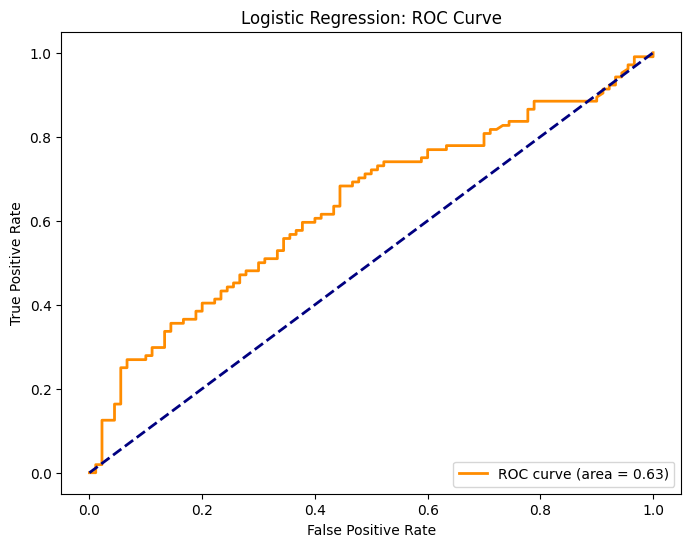

In [ ]:
#Logistic Model
X_train_log, X_test_log, y_train_log, y_test_log = X_train_knn, X_test_knn, y_train_knn, y_test_knn

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_log, y_train_log)

y_pred_log = logistic_model.predict(X_test_log)
logistic_accuracy = accuracy_score(y_test_log, y_pred_log)

print(f"Logistic Regression Accuracy: {logistic_accuracy}")

#code for the roc curve and auc to be able to analyze the relationship between viewership and video uploads

fpr, tpr, thresholds = roc_curve(y_test_log, logistic_model.predict_proba(X_test_log)[:, 1])
roc_auc = auc(fpr, tpr)

#creating the graph to have a visual representation of the ROC curve and AUC

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Logistic Regression: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Logistic Regression is ideal for binary classification issues because it provides probabilities that allow for variable decision thresholds. It is efficient, interpretable, and helpful for datasets having linear relationships between attributes and the target's the logarithmic likelihood. However, it may fail to detect complicated non-linear patterns. Its performance was assessed using the ROC AUC score, which provides a reliable measure of classification usefulness. Logistic Regression worked well when the binary classification aim was explicitly specified, owing to its simplicity and interpretability. The Area Under the Curve (AUC) score is used to assess the model's overall performance, with values closer to 1 indicating higher classification accuracy. In this situation, the AUC value of 0.63 indicates that the logistic regression model is moderately strong. The AUC score measures the likelihood of successfully predicting high video views based on upload count, demonstrating that the model accurately predicts high viewership 63% of the time. In particular, for a randomly selected channel from the "high-view" group and one from the "low-view" group, the model correctly identifies the "high-view" channel in 63% of cases. This indicates a modest association between increasing uploads and higher view counts.



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Model Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

       False       0.90      1.00      0.95        72
        True       0.00      0.00      0.00         8

    accuracy                           0.90        80
   macro avg       0.45      0.50      0.47        80
weighted avg       0.81      0.90      0.85        80



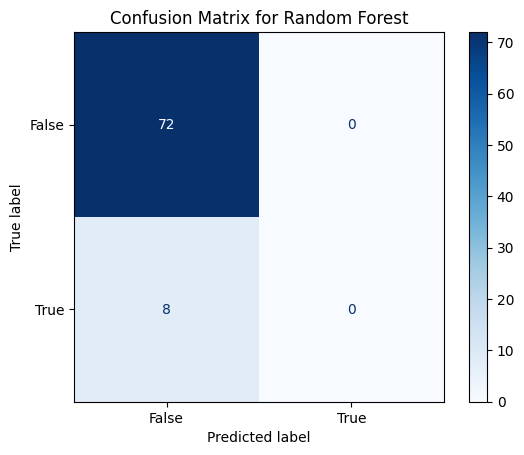

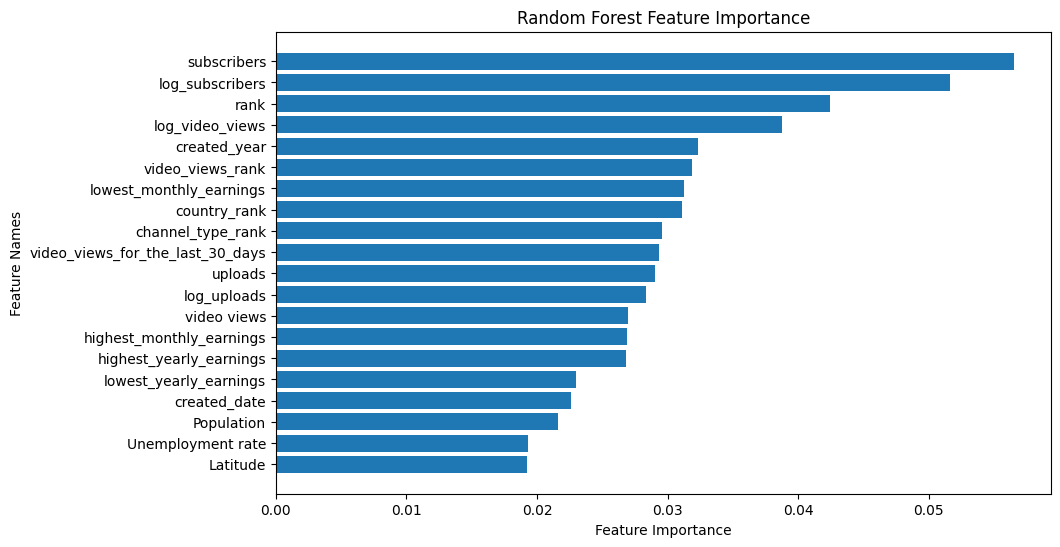

In [ ]:
# Random Forest Model

# Dropping rows with missing values to make sure we only work with complete data
df = df.dropna()

# Here we convert any non-numerical data into numbers so the model can understand it
# For example, if there's a "Yes/No" column, it might become "1/0"
data_encoded = pd.get_dummies(df, drop_first=True)

# The "target_column" is the thing we want to predict
# We use all the other columns as clues to help make that prediction
target_column = data_encoded.columns[-1] # Assuming the target is the last column
X = data_encoded.drop(columns=[target_column]) # Everything except the target
y = data_encoded[target_column] # The target itself

# Keep 80% of the data for training (teaching the model) and 20% for testing (seeing how well it learned)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

# Where the model learns from the training data
random_forest.fit(X_train, y_train)

# Now we're asking the model to predict the target for the test data
y_pred_rf = random_forest.predict(X_test)

# Accuracy tells us how the model got it right
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# The classification report gives more details like precision (how many predictions were correct for each class),
# recall (how many of the actual examples we caught), and F1-score (a balance between precision and recall)
rf_report = classification_report(y_test, y_pred_rf)

print("Random Forest Model Accuracy:", rf_accuracy)
print("\nClassification Report:\n", rf_report)

# This chart shows where the model got things right and wrong
# It helps us see which classes the model struggles with
ConfusionMatrixDisplay.from_estimator(random_forest, X_test, y_test, cmap="Blues", values_format='d')
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Random Forest can tell us which features or clues were the most helpful for making predictions
feature_importance = random_forest.feature_importances_

# Sort the features from most important to least important
sorted_idx = np.argsort(feature_importance)[::-1]
features = X.columns[sorted_idx]
importance_sorted = feature_importance[sorted_idx]

# Plotting the top 20 most important features
plt.figure(figsize=(10, 6))
num_features = 20 # Just looking at the top 20 features
plt.barh(features[:num_features], importance_sorted[:num_features])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

# The visualization below consists of bars, where each one represents a feature
# The longer the bar, the more that feature mattered for making predictions
# This helps us understand which factors are driving the model's decisions

The Random Forest model is a useful tool for making predictions. It works by combining the results of many decision trees, which makes it more accurate and less likely to overfit. This model is great for handling complex patterns in the data and can show which features are the most important for predictions. While it does take more time to run than more simple models, it does well with imbalanced datasets when we adjust for the smaller class. We evaluated its performance using accuracy, a classification report, and a confusion matrix.

When analyzing the results of the first graph, we see that it shows how many successful or unsuccessful YouTube channels were correctly or incorrectly classified. If we see a higher number of correct predictions for both categories, it means the model is doing well. For our feature importance graph, it highlights which factors were most influential in the model's predictions. Features like subscribers and rank might have the highest bars, showing they are the strongest predictors of YouTube success.

Ultimately, we were able to see how this model can help us to predict YouTube success rate strategies. The confusion matrix gives us a clear view of whether we can reliably predict "success" on YouTube based on the features we used, like subscribers, views, and upload frequency. In addtion, our feature importance graph does the same by showing which factors lead to a higher success rate. If upload frequency has high value, it suggests a strong relationship with success. Same goes for other factors such as video views or subscribers.